In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics
from scipy.ndimage import gaussian_filter
from sklearn.linear_model import LinearRegression

import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
def magnus_esat_ice(temperature):
    temperature = temperature - 273.15
    esat = 611.21*np.exp((22.587*temperature)/(temperature+273.86))

    return esat
    
def magnus_esat_water(temperature):
    temperature = temperature - 273.15
    esat = 610.94*np.exp((17.265*temperature)/(temperature+243.04))
    return esat

def MAGNUS(T):
    R = 287
    Rv = 461
    esat_water = magnus_esat_water(T)
    esat_ice = esat = magnus_esat_ice(T)
    esat_water[T < 273.15] = 0
    esat_ice[T >= 273.15] = 0
    esat = esat_ice+esat_water 
    return esat

In [3]:
def e_sat_general(temperature):
    temperature - 273.15
    esat_water = esat = (np.exp(34.494-(4924.99/(temperature+273.1))))/(temperature+105)**1.37
    esat_ice = (np.exp(43.494-(6545.8/(temperature+278.0))))/(temperature+868.0)**2
    esat_water[temperature < 0] = 0
    esat_ice[temperature >= 0] = 0
    esat = esat_ice+esat_water 
    return esat

In [4]:
def q_sat(temperature, pressure):
    top = (461./287.) * MAGNUS(temperature)
    bottom = pressure - (1 - (461./287.))*MAGNUS(temperature)
    return top / bottom

In [5]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [6]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [7]:
lat_keys = np.arange(0,22,1)
lat_values = latitudes
lon_keys = np.arange(0,144,1)
lon_values = longitudes

In [8]:
lat_dic = dict(zip(lat_values, lat_keys))
lon_dic = dict(zip(lon_values, lon_keys))

In [9]:
Precip_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Precip_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Lat_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lat_Test.npy")
Lon_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lon_Test.npy")
Lat_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lat_Test.npy")
Lon_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lon_Test.npy")

In [10]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/Mikes_Simulations/SST_CTL_Neuralnet_SPCAM_all_Grrifin_864_ens_05/atm/hist/SST_CTL_Neuralnet_SPCAM_all_Grrifin_**.cam.h1.2009*'
extra_variables = xr.open_mfdataset(path_to_file)

T_GCM_0K = extra_variables.T_LON_0e_to_360e_LAT_20s_to_20n
P_GCM_0K = extra_variables.PS_LON_0e_to_360e_LAT_20s_to_20n

In [11]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/Mikes_Simulations/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_864_ens_06/atm/hist/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_**.cam.h1.2009*'
extra_variables = xr.open_mfdataset(path_to_file)

T_GCM_4K = extra_variables.T_LON_0e_to_360e_LAT_20s_to_20n
P_GCM_4K = extra_variables.PS_LON_0e_to_360e_LAT_20s_to_20n

In [12]:
T_GCM_0K_sfc = T_GCM_0K[:,-1].mean(axis=0)
T_GCM_4K_sfc = T_GCM_4K[:,-1].mean(axis=0)
P_GCM_0K_sfc = P_GCM_0K.mean(axis=0)
P_GCM_4K_sfc = P_GCM_4K.mean(axis=0)

T_GCM_0K_sfc = T_GCM_0K_sfc.values
T_GCM_4K_sfc = T_GCM_4K_sfc.values
P_GCM_0K_sfc = P_GCM_0K_sfc.values
P_GCM_4K_sfc = P_GCM_4K_sfc.values

In [13]:
qsat_0K = q_sat(T_GCM_0K_sfc, P_GCM_0K_sfc)
qsat_4K = q_sat(T_GCM_4K_sfc, P_GCM_4K_sfc)

In [14]:
mean_changes = np.zeros(shape=(22,144))
mean_changes[:,:] = np.mean(Precip_4K - Precip_0K)

In [15]:
lat_lon_0K = np.zeros(shape=(22,144,500))
lat_lon_4K = np.zeros(shape=(22,144,500))
indexer_0K = np.zeros(shape=(22,144))
indexer_4K = np.zeros(shape=(22,144))
lat_lon_4K[:, :, :] = np.nan 
lat_lon_0K[:, :, :] = np.nan
count_0K = 0
count_4K = 0
for i in range(len(Precip_4K)):
    lat_lon_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]],int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]])] = Precip_0K[i]
    indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] = int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] + 1)
    lat_lon_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]],int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]])] = Precip_4K[i]
    indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] = int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] + 1)

In [16]:
P_001_0k = np.zeros(shape=(22,144))
P_01_0k = np.zeros(shape=(22,144))
P_1_0k = np.zeros(shape=(22,144))
P_5_0k = np.zeros(shape=(22,144))
P_25_0k = np.zeros(shape=(22,144))
P_50_0k = np.zeros(shape=(22,144))
P_75_0k = np.zeros(shape=(22,144))
P_90_0k = np.zeros(shape=(22,144))
P_95_0k = np.zeros(shape=(22,144))
P_99_0k = np.zeros(shape=(22,144))
P_999_0k = np.zeros(shape=(22,144))
P_9999_0k = np.zeros(shape=(22,144))

P_001_4k = np.zeros(shape=(22,144))
P_01_4k = np.zeros(shape=(22,144))
P_1_4k = np.zeros(shape=(22,144))
P_5_4k = np.zeros(shape=(22,144))
P_25_4k = np.zeros(shape=(22,144))
P_50_4k = np.zeros(shape=(22,144))
P_75_4k = np.zeros(shape=(22,144))
P_90_4k = np.zeros(shape=(22,144))
P_95_4k = np.zeros(shape=(22,144))
P_99_4k = np.zeros(shape=(22,144))
P_999_4k = np.zeros(shape=(22,144))
P_9999_4k = np.zeros(shape=(22,144))

for i in range(len(lat_lon_0K)):
    for j in range(len(lat_lon_0K[0])):
        P_001_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.01)
        P_01_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.1)
        P_1_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 1)
        P_5_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 5)
        P_25_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 25)
        P_50_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 50)
        P_75_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 75)
        P_90_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 90)
        P_95_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 95)
        P_99_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99)
        P_999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.9)
        P_9999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.99)
        
        P_001_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.01)
        P_01_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.1)
        P_1_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 1)
        P_5_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 5)
        P_25_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 25)
        P_50_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 50)
        P_75_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 75)
        P_90_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 90)
        P_95_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 95)
        P_99_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99)
        P_999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.9)
        P_9999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.99)

In [17]:
def proportion_maker(array, lats, lons, my_lat_dic, my_lon_dic):
    group_one = np.zeros(shape=(22, 144))
    group_two = np.zeros(shape=(22, 144))
    group_three = np.zeros(shape=(22, 144))
    proportion_one = np.zeros(shape=(22, 144))
    proportion_two = np.zeros(shape=(22, 144))
    proportion_three = np.zeros(shape=(22, 144))
    for i in range(len(array)):
        if array[i] == 0:
            group_one[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_one[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
        if array[i] == 1:
            group_two[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_two[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
        if array[i] == 2:
            group_three[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] = group_three[my_lat_dic[lats[i]],my_lon_dic[lons[i]]] + 1
    
    proportion_one = group_one / (group_one + group_two + group_three)
    proportion_two = group_two / (group_one + group_two + group_three)
    proportion_three = group_three / (group_one + group_two + group_three)
    
    return proportion_one, proportion_two, proportion_three

In [18]:
vae_labels_4K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_4k_Mandt_Method_3099_Z_3.npy")
vae_labels_0K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Mooers_Logbook/Fully_Convolutional_W/Clustering_Routine/Compressed_Data/Precip_0K_Big_SPCAM_Labels_3099_Z_3.npy")


In [19]:
vae_proportion_0K_one, vae_proportion_0K_two, vae_proportion_0K_three = proportion_maker(vae_labels_0K, Lat_0K, Lon_0K, lat_dic, lon_dic)
vae_proportion_4K_one, vae_proportion_4K_two, vae_proportion_4K_three = proportion_maker(vae_labels_4K, Lat_4K, Lon_4K, lat_dic, lon_dic)


In [20]:
vae_shallow = vae_proportion_4K_one - vae_proportion_0K_one
vae_deep = vae_proportion_4K_two - vae_proportion_0K_two
vae_green = vae_proportion_4K_three - vae_proportion_0K_three

In [21]:
def lin_reg_vae(P, q_sat, Pi_1, Pi_2):
    reg = LinearRegression(fit_intercept=True, normalize=False)
    y = P / q_sat 
    y_lin_reg = gaussian_filter(y, 2, mode='nearest').ravel()
    
    X = np.empty(shape=(Pi_1.size, 2))
    X[:, 0] = gaussian_filter(Pi_1, 2, mode='nearest').ravel()
    X[:, 1] = gaussian_filter(Pi_2, 2, mode='nearest').ravel()


    reg.fit(X, y_lin_reg)
    return reg.score(X, y_lin_reg), reg.coef_, reg.intercept_

In [22]:
def lin_reg(P, q_sat, Pi_1, Pi_2):
    reg = LinearRegression(fit_intercept=True, normalize=False)
    
    #y = y_maker(P_Zero, P_Four, q_sat_mean)
    y = P / q_sat 
    y_lin_reg = gaussian_filter(y, 2, mode='nearest').ravel()
    
    X = np.empty(shape=(Pi_1.size, 2))
    X[:, 0] = gaussian_filter(Pi_1, 2, mode='nearest').ravel()
    X[:, 1] = gaussian_filter(Pi_2, 2, mode='nearest').ravel()


    reg.fit(X, y_lin_reg)
    return reg.score(X, y_lin_reg), reg.coef_, reg.intercept_

In [23]:
y_0K_Coeff_vae = np.array([lin_reg_vae(P_001_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_01_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_1_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_5_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_25_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_50_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_75_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_95_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_99_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_999_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[1],
    lin_reg_vae(P_9999_0k, qsat_0K, vae_proportion_0K_one,vae_proportion_0K_two)[1]])

y_4K_Coeff_vae = np.array([lin_reg_vae(P_001_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_01_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_1_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_5_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_25_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_50_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_75_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_95_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_99_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1],
    lin_reg_vae(P_9999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[1]])

In [24]:
y_0K_Intercept = [lin_reg(P_001_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_01_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_1_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_5_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_25_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_50_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_75_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_95_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_99_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_999_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2],
    lin_reg(P_9999_0k, qsat_0K, vae_proportion_0K_one, vae_proportion_0K_two)[2]]

y_4K_Intercept = [lin_reg(P_001_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_01_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_1_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_5_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_25_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_50_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_75_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_95_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_99_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2],
    lin_reg(P_9999_4k, qsat_4K, vae_proportion_4K_one, vae_proportion_4K_two)[2]]

In [25]:
D_shallow_0K = np.empty(shape=(22, 144))
D_deep_0K = np.empty(shape=(22, 144))
D_shallow_0K[:,:] = y_0K_Coeff_vae[-4,1]
D_deep_0K[:,:] = y_0K_Coeff_vae[-4,0]

D_shallow_4K = np.empty(shape=(22, 144))
D_deep_4K = np.empty(shape=(22, 144))
D_shallow_4K[:,:] = y_4K_Coeff_vae[-4,1]
D_deep_4K[:,:] = y_4K_Coeff_vae[-4,0]

Do = np.empty(shape=(22, 144))
Do[:,:] = qsat_4K*(np.array(y_4K_Intercept[-4])-np.array(y_0K_Intercept[-4]))

In [26]:
deep_conv_regime_shift = qsat_4K*vae_deep*D_deep_4K
shallow_conv_regime_shift = qsat_4K*vae_shallow*D_shallow_4K 

changes_in_deep_conv_dynamics = qsat_4K*(D_deep_4K - D_deep_0K)*vae_proportion_4K_two
changes_in_shallow_conv_dynamics = qsat_4K*(D_shallow_4K - D_shallow_0K)*vae_proportion_4K_one

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


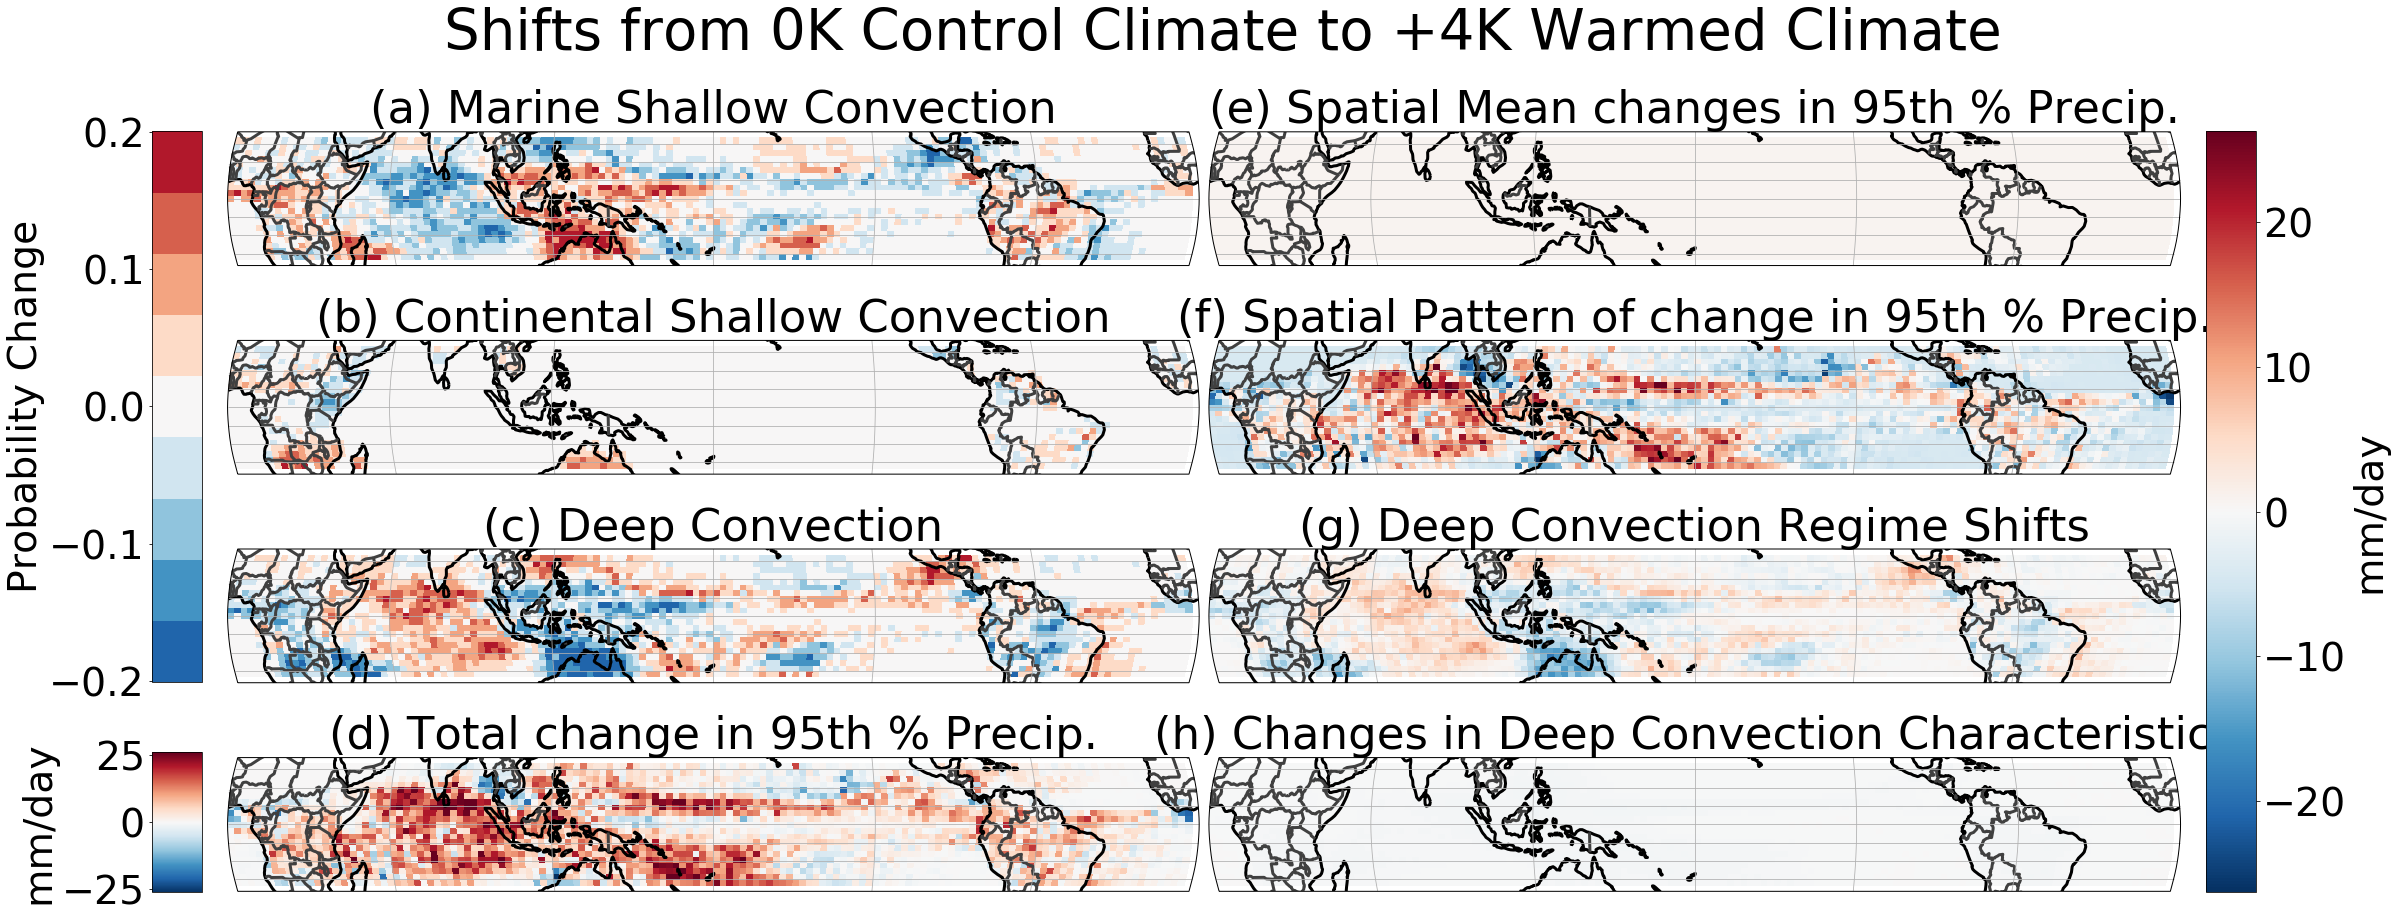

In [27]:
vmin = -1.0*np.max(np.abs(vae_deep))/1.5
vmax = np.max(np.abs(vae_deep))/1.5

cmap = ListedColormap(sns.color_palette("RdBu_r", n_colors = 9))

fig, ax = plt.subplots(4,2,figsize=(35,15),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

contour_plot = ax[0,0].pcolormesh(new_lons, new_lats, vae_shallow, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[0,0].coastlines(linewidth=3,edgecolor='0.25') 
ax[0,0].gridlines()
ax[0,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[0,0].set_title("(a) Marine Shallow Convection", fontsize = fz*2)

contour_plot = ax[1,0].pcolormesh(new_lons, new_lats, vae_green, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[1,0].coastlines(linewidth=3,edgecolor='0.25')
ax[1,0].gridlines()
ax[1,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[1,0].set_title("(b) Continental Shallow Convection", fontsize = fz*2)

contour_plot = ax[2,0].pcolormesh(new_lons, new_lats, vae_deep, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[2,0].coastlines(linewidth=3,edgecolor='0.25')
ax[2,0].gridlines()
ax[2,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[2,0].set_title("(c) Deep Convection", fontsize = fz*2)

cax_2 = fig.add_axes([0.095, 0.345, 0.02, 0.51])
cb_2 = fig.colorbar(contour_plot, cax=cax_2)
cb_2.set_label('Probability Change', fontsize=fz*1.75)
cb_2.ax.tick_params(labelsize=fz*1.75)
cax_2.yaxis.set_ticks_position('left')
cax_2.yaxis.set_label_position('left')

vmax = np.percentile(np.abs(P_95_4k - P_95_0k), 99)
vmin = -vmax
cmap = "RdBu_r"

contour_plot = ax[3,0].pcolormesh(new_lons, new_lats, P_95_4k - P_95_0k, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[3,0].coastlines(linewidth=3,edgecolor='0.25') 
ax[3,0].gridlines()
ax[3,0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[3,0].set_title("(d) Total change in 95th % Precip.", fontsize = fz*2)

cax_2 = fig.add_axes([0.095, 0.15, 0.02, 0.13])
cb_2 = fig.colorbar(contour_plot, cax=cax_2)
cb_2.set_label('mm/day', fontsize=fz*1.75)
cb_2.ax.tick_params(labelsize=fz*1.75)
cax_2.yaxis.set_ticks_position('left')
cax_2.yaxis.set_label_position('left')

contour_plot = ax[0,1].pcolormesh(new_lons, new_lats, mean_changes, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[0,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[0,1].gridlines()
ax[0,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[0,1].set_title("(e) Spatial Mean changes in 95th % Precip.", fontsize = fz*2)

contour_plot = ax[1,1].pcolormesh(new_lons, new_lats, P_95_4k - P_95_0k - np.mean(P_95_4k - P_95_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[1,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[1,1].gridlines()
ax[1,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[1,1].set_title("(f) Spatial Pattern of change in 95th % Precip.", fontsize = fz*2)

cax_3 = fig.add_axes([0.91, 0.15, 0.02, 0.705])
cb_3 = fig.colorbar(contour_plot, cax=cax_3)
cb_3.set_label('mm/day', fontsize=fz*1.75)
cb_3.ax.tick_params(labelsize=fz*1.75)

contour_plot = ax[2,1].pcolormesh(new_lons, new_lats, deep_conv_regime_shift, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[2,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[2,1].gridlines()
ax[2,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[2,1].set_title("(g) Deep Convection Regime Shifts", fontsize = fz*2)

contour_plot = ax[3,1].pcolormesh(new_lons, new_lats, changes_in_deep_conv_dynamics, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[3,1].coastlines(linewidth=3,edgecolor='0.25') 
ax[3,1].gridlines()
ax[3,1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[3,1].set_title("(h) Changes in Deep Convection Characteristics", fontsize = fz*2)

plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.suptitle("Shifts from 0K Control Climate to +4K Warmed Climate", y = 0.97, x = 0.52, fontsize=fz*2.5)
plt.savefig("Figures/Spatial_Patterns.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("Figures/Spatial_Patterns.pdf", bbox_inches='tight',pad_inches = 0)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.


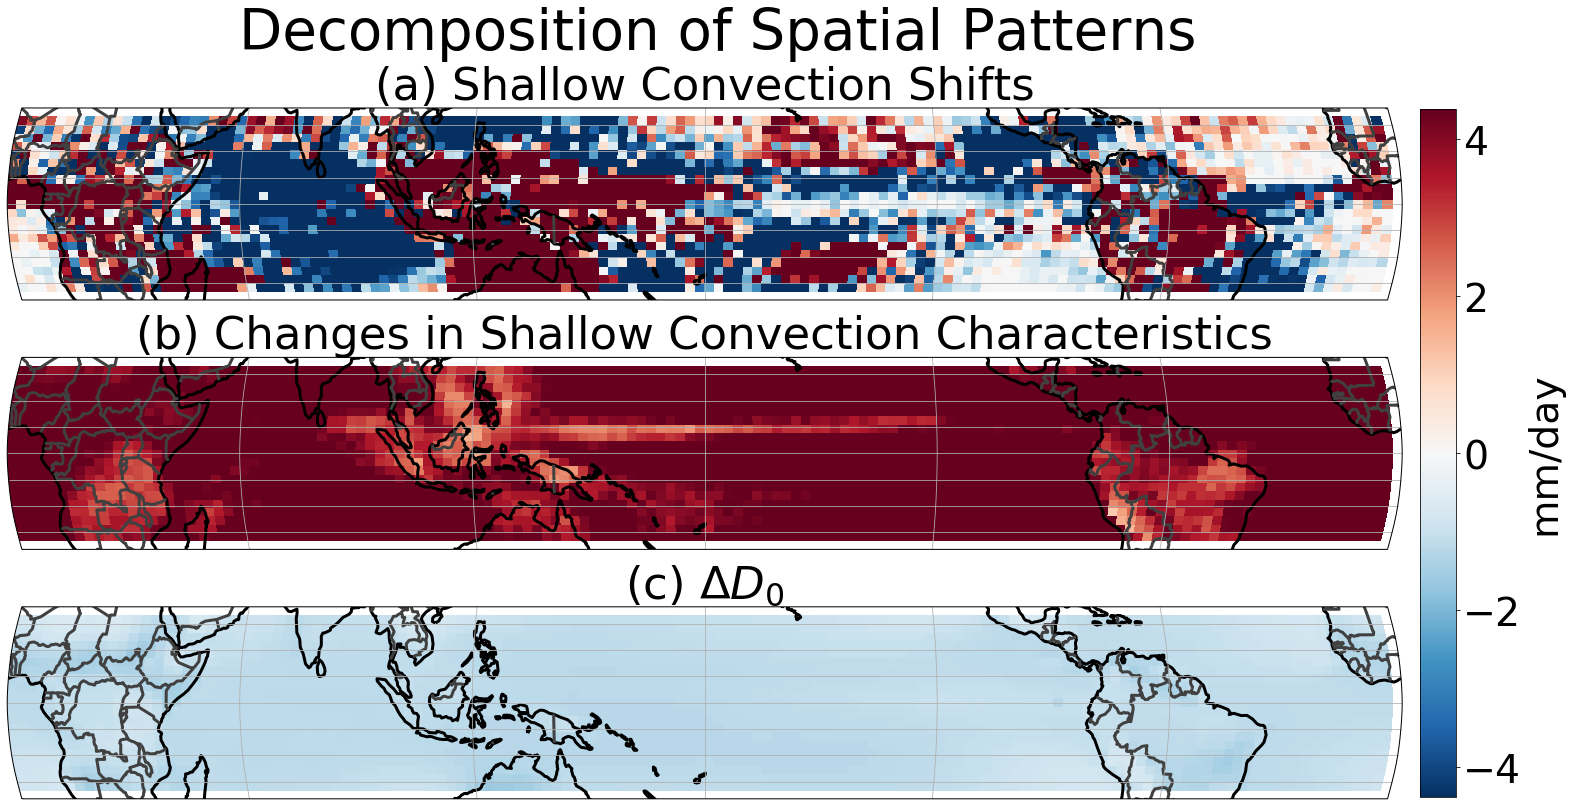

In [28]:
vmax = np.percentile(np.abs(P_95_4k - P_95_0k), 99)/6
vmin = -vmax
cmap = "RdBu_r"

fig, ax = plt.subplots(3,1,figsize=(25,13),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

contour_plot = ax[0].pcolormesh(new_lons, new_lats, shallow_conv_regime_shift, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[0].coastlines(linewidth=3,edgecolor='0.25') 
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[0].set_title("(a) Shallow Convection Shifts", fontsize = fz*2)

contour_plot = ax[1].pcolormesh(new_lons, new_lats, changes_in_shallow_conv_dynamics, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[1].coastlines(linewidth=3,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[1].set_title("(b) Changes in Shallow Convection Characteristics", fontsize = fz*2)

contour_plot = ax[2].pcolormesh(new_lons, new_lats, Do, cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[2].coastlines(linewidth=3,edgecolor='0.25')
ax[2].gridlines()
ax[2].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[2].set_title("(c) "+r"$ \Delta D_0$", fontsize = fz*2)

cax_3 = fig.add_axes([0.91, 0.135, 0.02, 0.735])
cb_3 = fig.colorbar(contour_plot, cax=cax_3)
cb_3.set_label('mm/day', fontsize=fz*1.75)
cb_3.ax.tick_params(labelsize=fz*1.75)

#plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.suptitle("Decomposition of Spatial Patterns", y = 0.98, x = 0.52, fontsize=fz*2.5)
plt.savefig("Figures/Equation_1_Decomposition.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("Figures/Equation_1_Decomposition.pdf", bbox_inches='tight',pad_inches = 0)